In [1]:
# Initializing Model and First Analysis Run
import os
nLoadCases = 150
os.environ["MAX_LOADCASE"] = str(nLoadCases)

from scipy import sparse as sp
import numpy as np
from Examples.RDSO45mTruss.Structure3D import Structure3D
from Models import DOFClass
import matplotlib.pyplot as plt

# Defining the structure
structure = Structure3D()

# Loading ImbalancedActionVector from File
ImbalancedActionVectorFromFile = sp.lil_array(sp.load_npz(f'DataExchange/.ImbalancedActionVector{nLoadCases}.npz'))
DOFClass.ImbalancedActionVector = ImbalancedActionVectorFromFile.copy()

# Analysing file
staticDisplacementVector = DOFClass.analyse()
maxMidSpanStaticDisplacement = np.min(staticDisplacementVector)
print(f"Maximum displacement @ midspan for static speed case is {maxMidSpanStaticDisplacement}")

C:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Maximum displacement @ midspan for static speed case is -0.025795573285401288


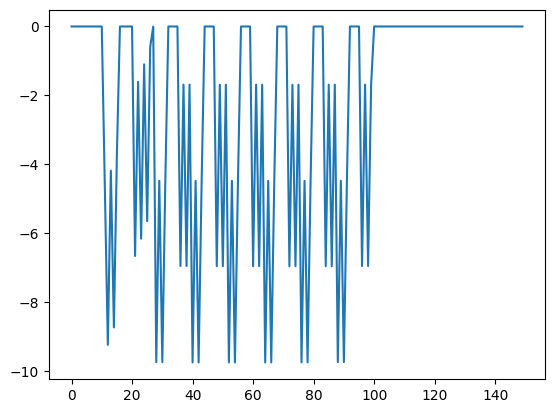

In [2]:
plt.plot(ImbalancedActionVectorFromFile[[structure.stringers[0].nodes[0].DOF[2].id],:].todense().flatten()/9806)

Maximum displacement @ midspan for 0.01kmph speed case is -0.02494869885861608
Maximum displacement @ midspan for 5kmph speed case is -0.024947099751758607
Maximum displacement @ midspan for 20kmph speed case is -0.024944658726846262
Maximum displacement @ midspan for 40kmph speed case is -0.024857841764669316
Maximum displacement @ midspan for 70kmph speed case is -0.02492956999400272
Maximum displacement @ midspan for 100kmph speed case is -0.025034056518807888
Maximum displacement @ midspan for 160kmph speed case is -0.025057706598783622
Maximum displacement @ midspan for 200kmph speed case is -0.02521526573197167
Maximum displacement @ midspan for 400kmph speed case is -0.024910667776754297
Maximum displacement @ midspan for 1000kmph speed case is -0.02977225877256692
Maximum displacement @ midspan for 2000kmph speed case is -0.036901343815781196


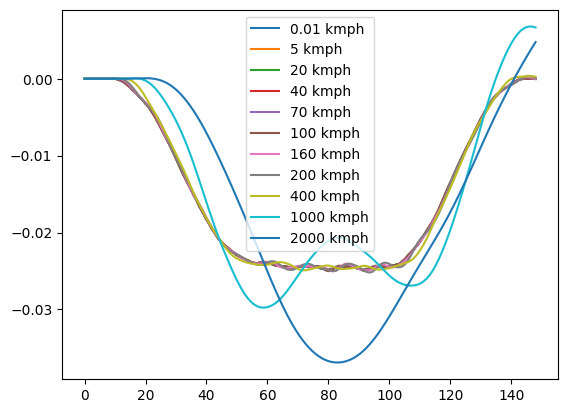

In [8]:
import numpy as np
import matplotlib.pyplot as plt

nModes = 50
eigenValues, eigenVectors, effectiveMass, massParticipationFactor = DOFClass.eig(nModes)
dampingRatios = np.ones((nModes,), np.float64) * 0.1

DOFClass.ImbalancedActionVector = ImbalancedActionVectorFromFile.copy()

def performTimeHistoryAnalysis(speed_kmph):
  speed_mps = speed_kmph/3.6
  dt = 150/speed_mps/nLoadCases
  timeHistoryDisplacementVector, timeHistoryVelocityVector, timeHistoryAccelerationVector = DOFClass.analyseTimeHistory(dt, eigenValues, eigenVectors, dampingRatios)
  midSpanMaxDisplacement = np.min(timeHistoryDisplacementVector[structure.truss1.node_by_name("L4").DOF[2].id,:])
  print(f"Maximum displacement @ midspan for {speed_kmph}kmph speed case is {midSpanMaxDisplacement}")
  plt.plot(x, timeHistoryDisplacementVector[structure.truss1.node_by_name("L4").DOF[2].id,:], label=f"{speed_kmph} kmph")

x = np.arange(nLoadCases)/nLoadCases*(150*nLoadCases/(nLoadCases+1))
# plt.plot(x, staticDisplacementVector[structure.truss1.node_by_name("L4").DOF[2].id,:], label=f"static")
performTimeHistoryAnalysis(0.01)
performTimeHistoryAnalysis(5)
performTimeHistoryAnalysis(20)
performTimeHistoryAnalysis(40)
performTimeHistoryAnalysis(70)
performTimeHistoryAnalysis(100)
performTimeHistoryAnalysis(160)
performTimeHistoryAnalysis(200)
performTimeHistoryAnalysis(400)
performTimeHistoryAnalysis(1000)
performTimeHistoryAnalysis(2000)
plt.legend()
plt.show()

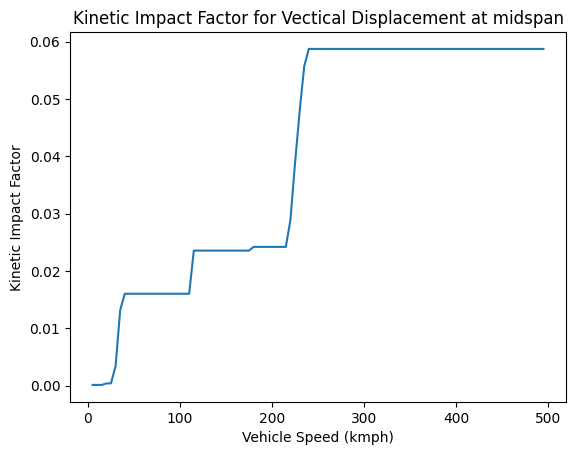

In [9]:
import numpy as np
import matplotlib.pyplot as plt

nModes = 50
eigenValues, eigenVectors, effectiveMass, massParticipationFactor = DOFClass.eig(nModes)
dampingRatios = np.ones((nModes,), np.float64) * 0.02

DOFClass.ImbalancedActionVector = ImbalancedActionVectorFromFile.copy()

def getMaxMidSpanDisplacementTimeHistoryAnalysis(speed_kmph):
  speed_mps = speed_kmph/3.6
  dt = 150/speed_mps/nLoadCases
  timeHistoryDisplacementVector, timeHistoryVelocityVector, timeHistoryAccelerationVector = DOFClass.analyseTimeHistory(dt, eigenValues, eigenVectors, dampingRatios)
  midSpanMaxDisplacement = np.min(timeHistoryDisplacementVector[structure.truss1.node_by_name("L4").DOF[2].id,:])
  # print(f"Maximum displacement @ midspan for {speed_kmph}kmph speed case is {midSpanMaxDisplacement}")
  return midSpanMaxDisplacement

maxMidSpanStaticDisplacement = getMaxMidSpanDisplacementTimeHistoryAnalysis(0.01)
speeds = list(range(5,500,5))
maxMidspanDisplacement = []
maxFactor = 0
for speed in speeds:
  maxFactor = max(getMaxMidSpanDisplacementTimeHistoryAnalysis(speed)/maxMidSpanStaticDisplacement - 1, maxFactor)
  maxMidspanDisplacement.append(maxFactor)
  
plt.plot(speeds, maxMidspanDisplacement)
plt.title("Kinetic Impact Factor for Vectical Displacement at midspan")
plt.ylabel("Kinetic Impact Factor")
plt.xlabel("Vehicle Speed (kmph)")
plt.show()

In [25]:
# Live Load Results from Sensor Data
import pandas as pd
import matplotlib.pyplot as plt

def getLLDataFromFile(_FILENAME, _filterStrainRegex='', _filterDispRegex='', _startTime=0, _endTime=100000, _filterStartTime=0, _filterEndTime=10) -> pd.DataFrame:
  _dfSensorRaw = pd.read_csv(_FILENAME, sep='\t')
  _dfSensorRaw["Time"] = _dfSensorRaw["Time"].apply(pd.to_timedelta)
  _dfSensorRaw["Time"] = (_dfSensorRaw["Time"] - _dfSensorRaw["Time"].min()).dt.total_seconds()
  _dfSensorRaw = _dfSensorRaw.set_index("Time")
  _dfSensorRaw.index.name = "Time (s)"
  _dfSensorRaw = _dfSensorRaw.filter(regex='^[Sd]')
  if _filterStrainRegex != '':
    _dfSensorRaw = _dfSensorRaw.filter(regex=_filterStrainRegex)
  if _filterDispRegex != '':
    _dfSensorRaw = _dfSensorRaw.filter(regex=_filterDispRegex)
  
  # removing the constant value using filterStartTime and filterEndTime
  _dfSensorRaw = _dfSensorRaw - _dfSensorRaw.iloc[(_dfSensorRaw.index>=_filterStartTime) & (_dfSensorRaw.index<=_filterEndTime)].mean()

  # Trimming outside startTime and endTime
  _dfSensorRaw = _dfSensorRaw[(_dfSensorRaw.index>=_startTime) & (_dfSensorRaw.index<=_endTime)]

  return _dfSensorRaw

dfSensor5 = getLLDataFromFile('span30/5kmcr.txt', _filterStrainRegex=r'^(?!(S33|S37|S38|S39|S40))', _filterDispRegex=r'^(?!(d7))', _startTime=125, _endTime=1000, _filterStartTime=0, _filterEndTime=10)
dfSensor20 = getLLDataFromFile('span30/20km.txt', _filterStrainRegex=r'^(?!(S33|S37|S38|S39|S40))', _filterDispRegex=r'^(?!(d7))', _startTime=35, _endTime=1000, _filterStartTime=0, _filterEndTime=10)
dfSensor40 = getLLDataFromFile('span30/40km.txt', _filterStrainRegex=r'^(?!(S33|S37|S38|S39|S40))', _filterDispRegex=r'^(?!(d7))', _startTime=17, _endTime=1000, _filterStartTime=0, _filterEndTime=10)
dfSensor70 = getLLDataFromFile('span30/70km.txt', _filterStrainRegex=r'^(?!(S33|S37|S38|S39|S40))', _filterDispRegex=r'^(?!(d7))', _startTime=20, _endTime=1000, _filterStartTime=0, _filterEndTime=10)

In [26]:
# Scaling and Shift all the dataframes using 5kmcr.txt as source
import pandas as pd

def shiftAndScaleTargetSignal(_dfTarget:pd.DataFrame, _dfSource:pd.DataFrame) -> None:
  # Calculating mean for both dataframes
  _dfNumericalRawMean = _dfTarget.mul(_dfTarget.index, axis=0).mean()/_dfTarget.mean()
  _dfSensorRawMean = _dfSource.mul(_dfSource.index, axis=0).mean()/_dfSource.mean()

  # Calculating Standard Deviation for both dataframes
  _dfNumericalRawSD = _dfTarget.mul(_dfTarget.index**2, axis=0).mean()/_dfTarget.mean() - _dfNumericalRawMean**2
  _dfSensorRawSD = _dfSource.mul(_dfSource.index**2, axis=0).mean()/_dfSource.mean() - _dfSensorRawMean**2

  # Calculating scale and shift in both dataFrames
  _scale = ((_dfSensorRawSD/_dfNumericalRawSD).mean())**0.5
  _shift = (_dfSensorRawMean-_dfNumericalRawMean*(_dfSensorRawSD/_dfNumericalRawSD)**0.5).mean()
  
  # print(f"{_scale=}", f"{_shift=}")
  # Scaling and Shifting the Target
  _dfTarget.index = _dfTarget.index*_scale + _shift

dfSensor5.index = reversed(dfSensor5.index.to_list())
dfSensor5 = dfSensor5[::-1]
shiftAndScaleTargetSignal(dfSensor20, dfSensor5)
shiftAndScaleTargetSignal(dfSensor40, dfSensor5)
shiftAndScaleTargetSignal(dfSensor70, dfSensor5)

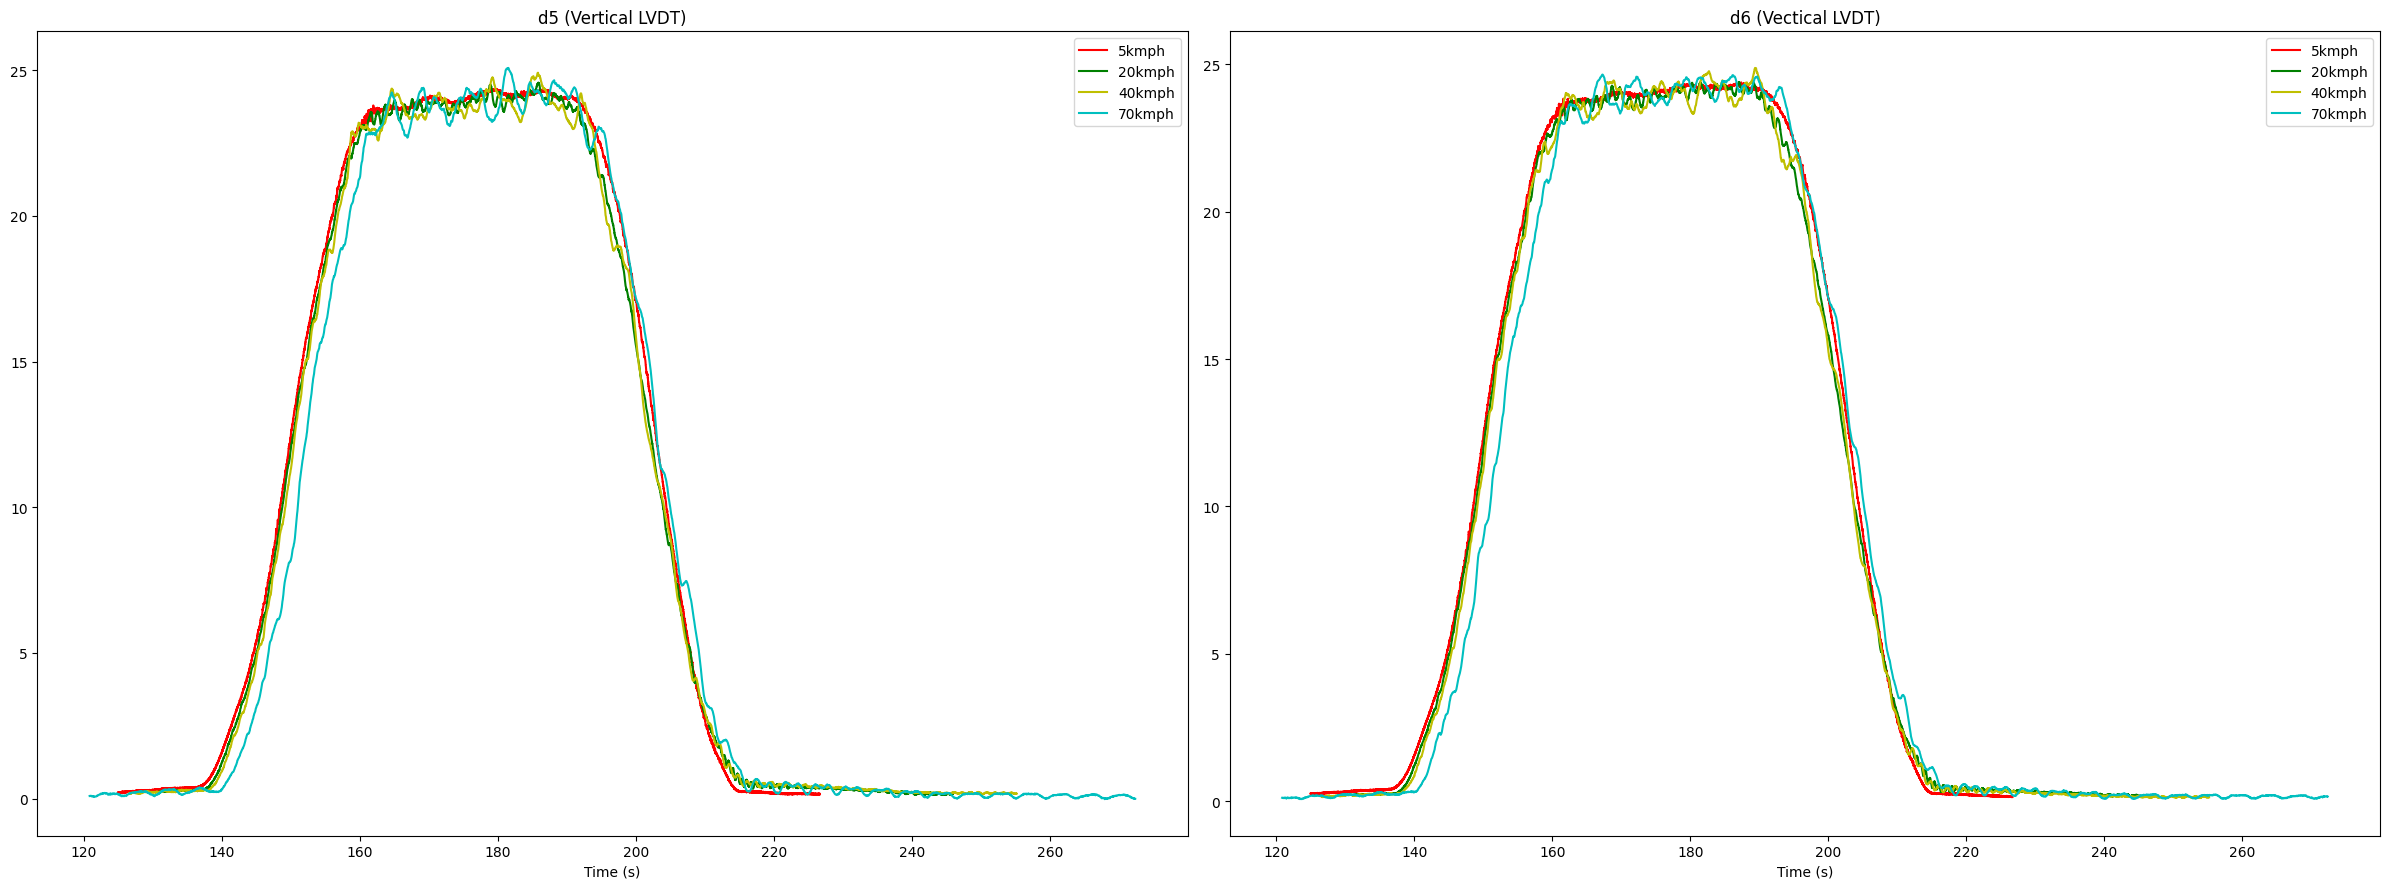

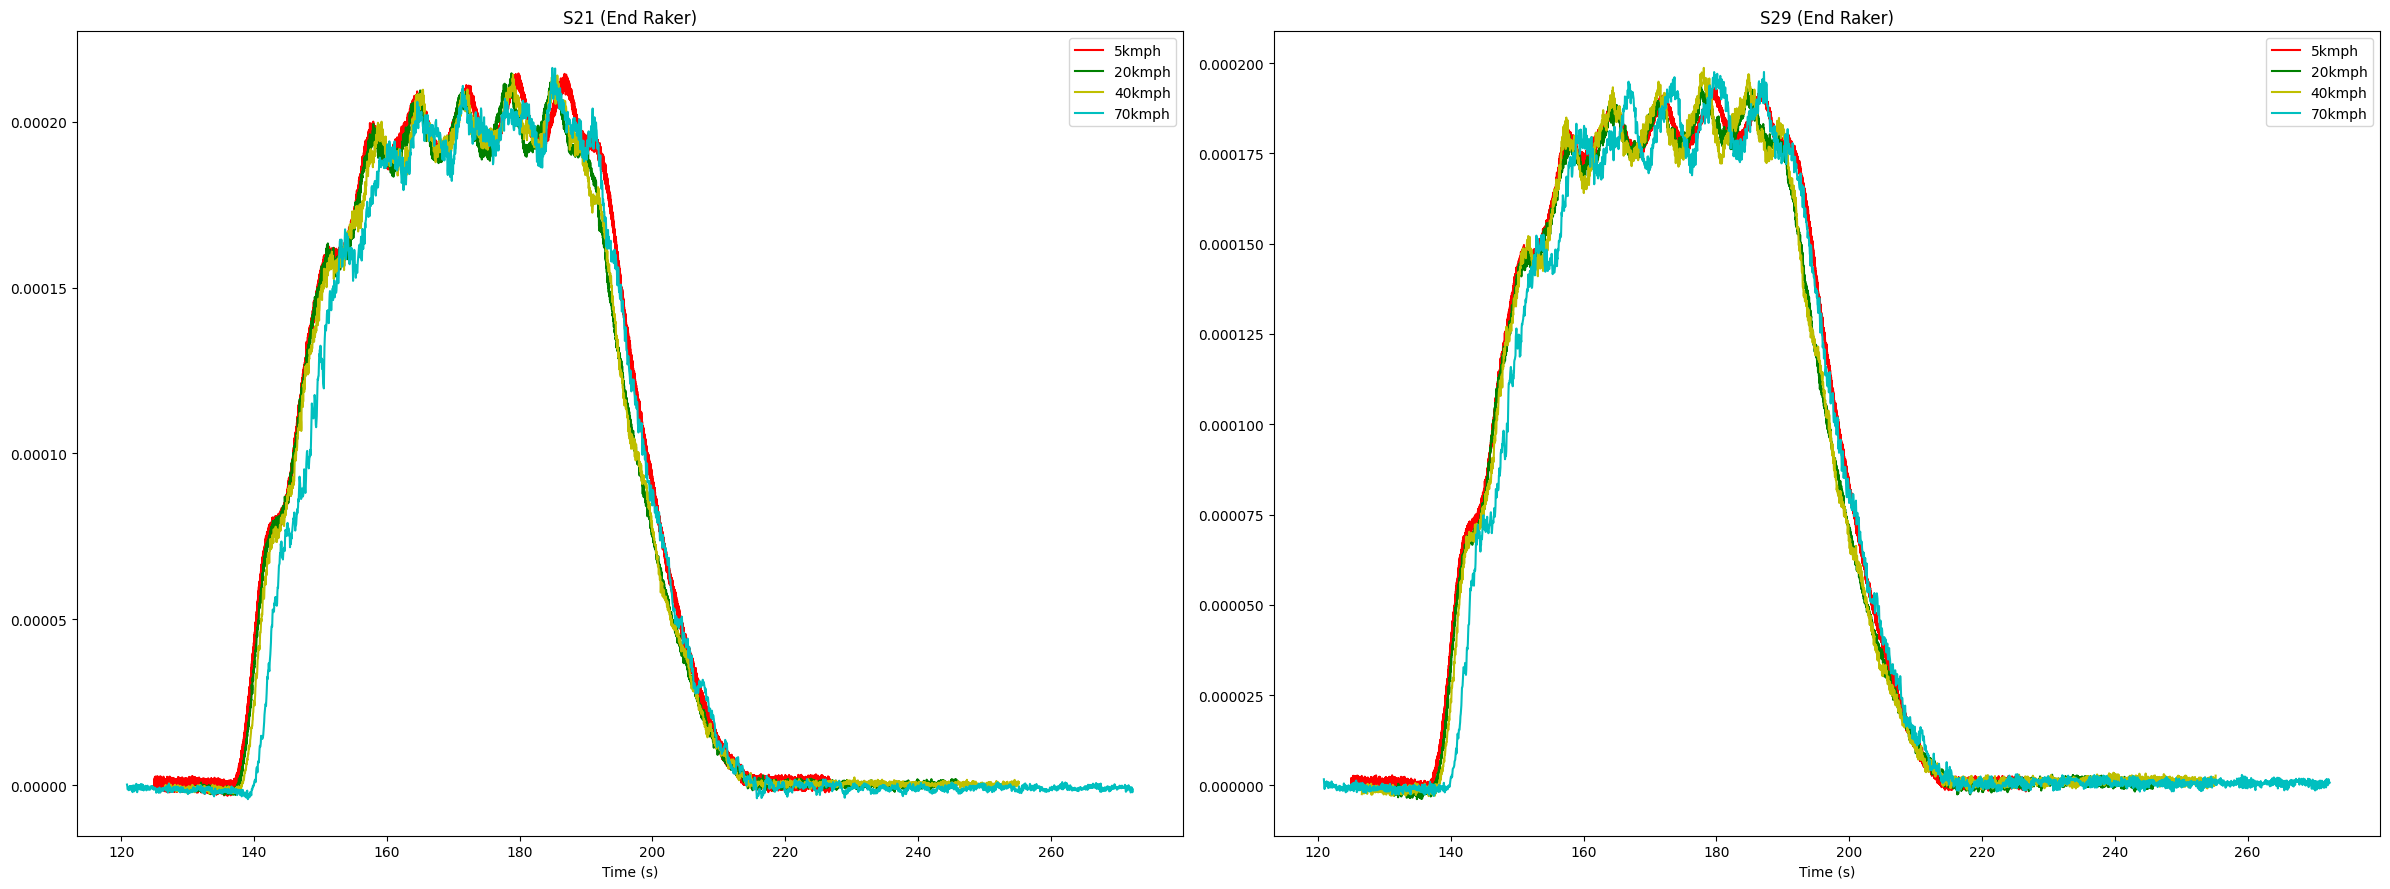

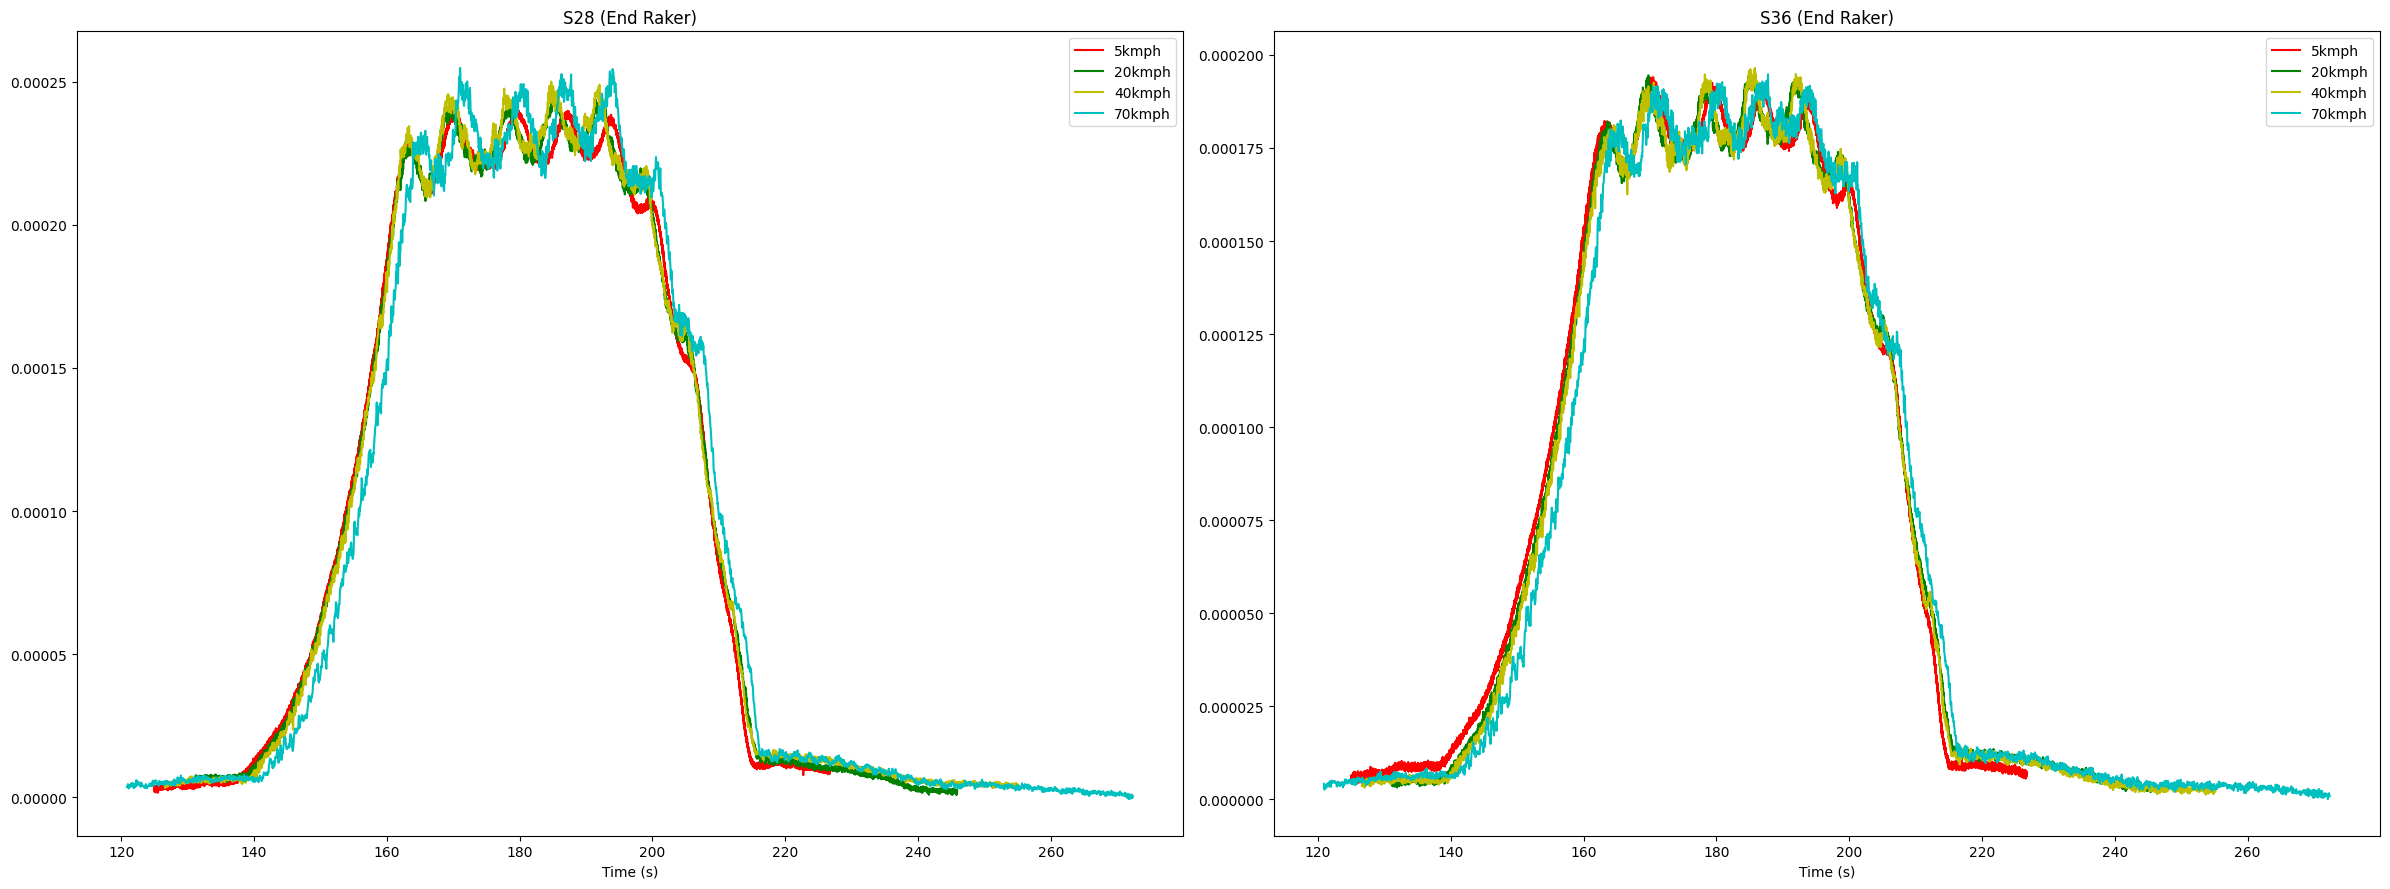

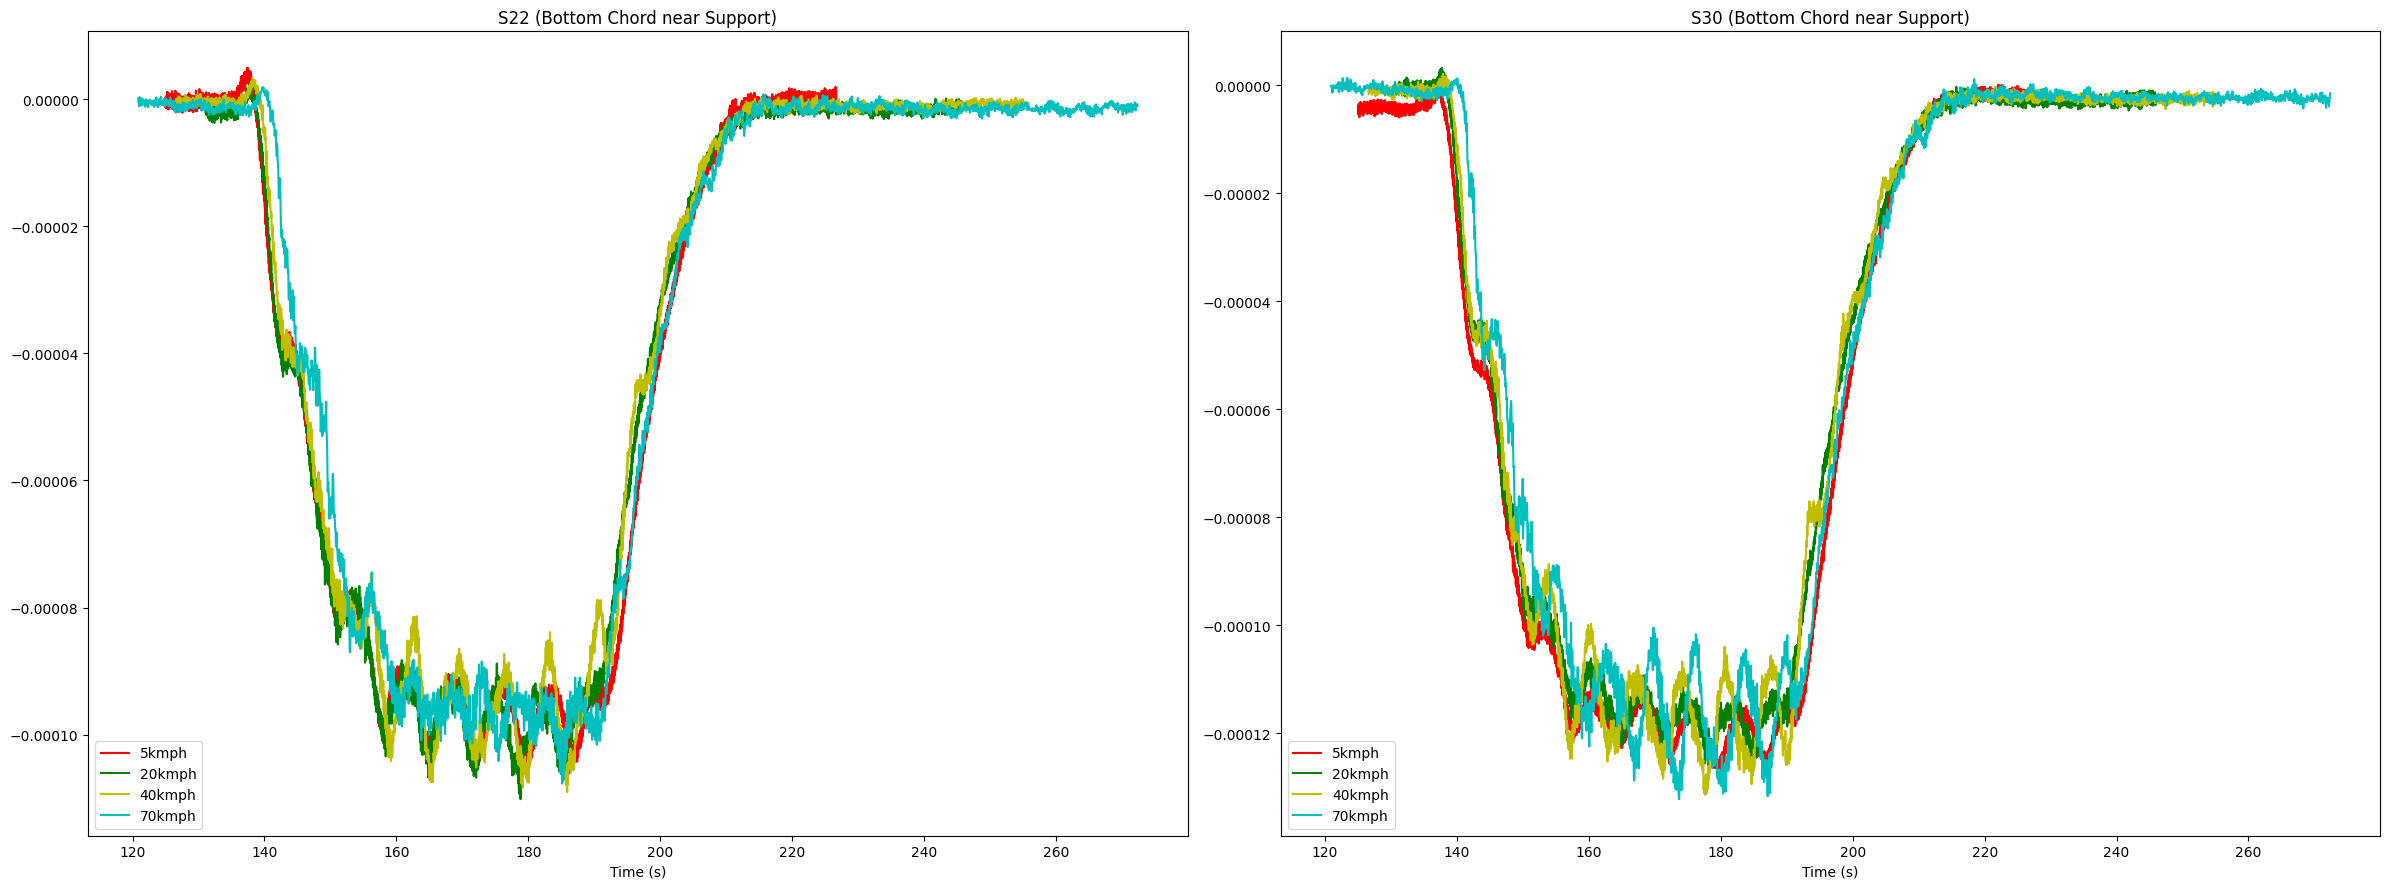

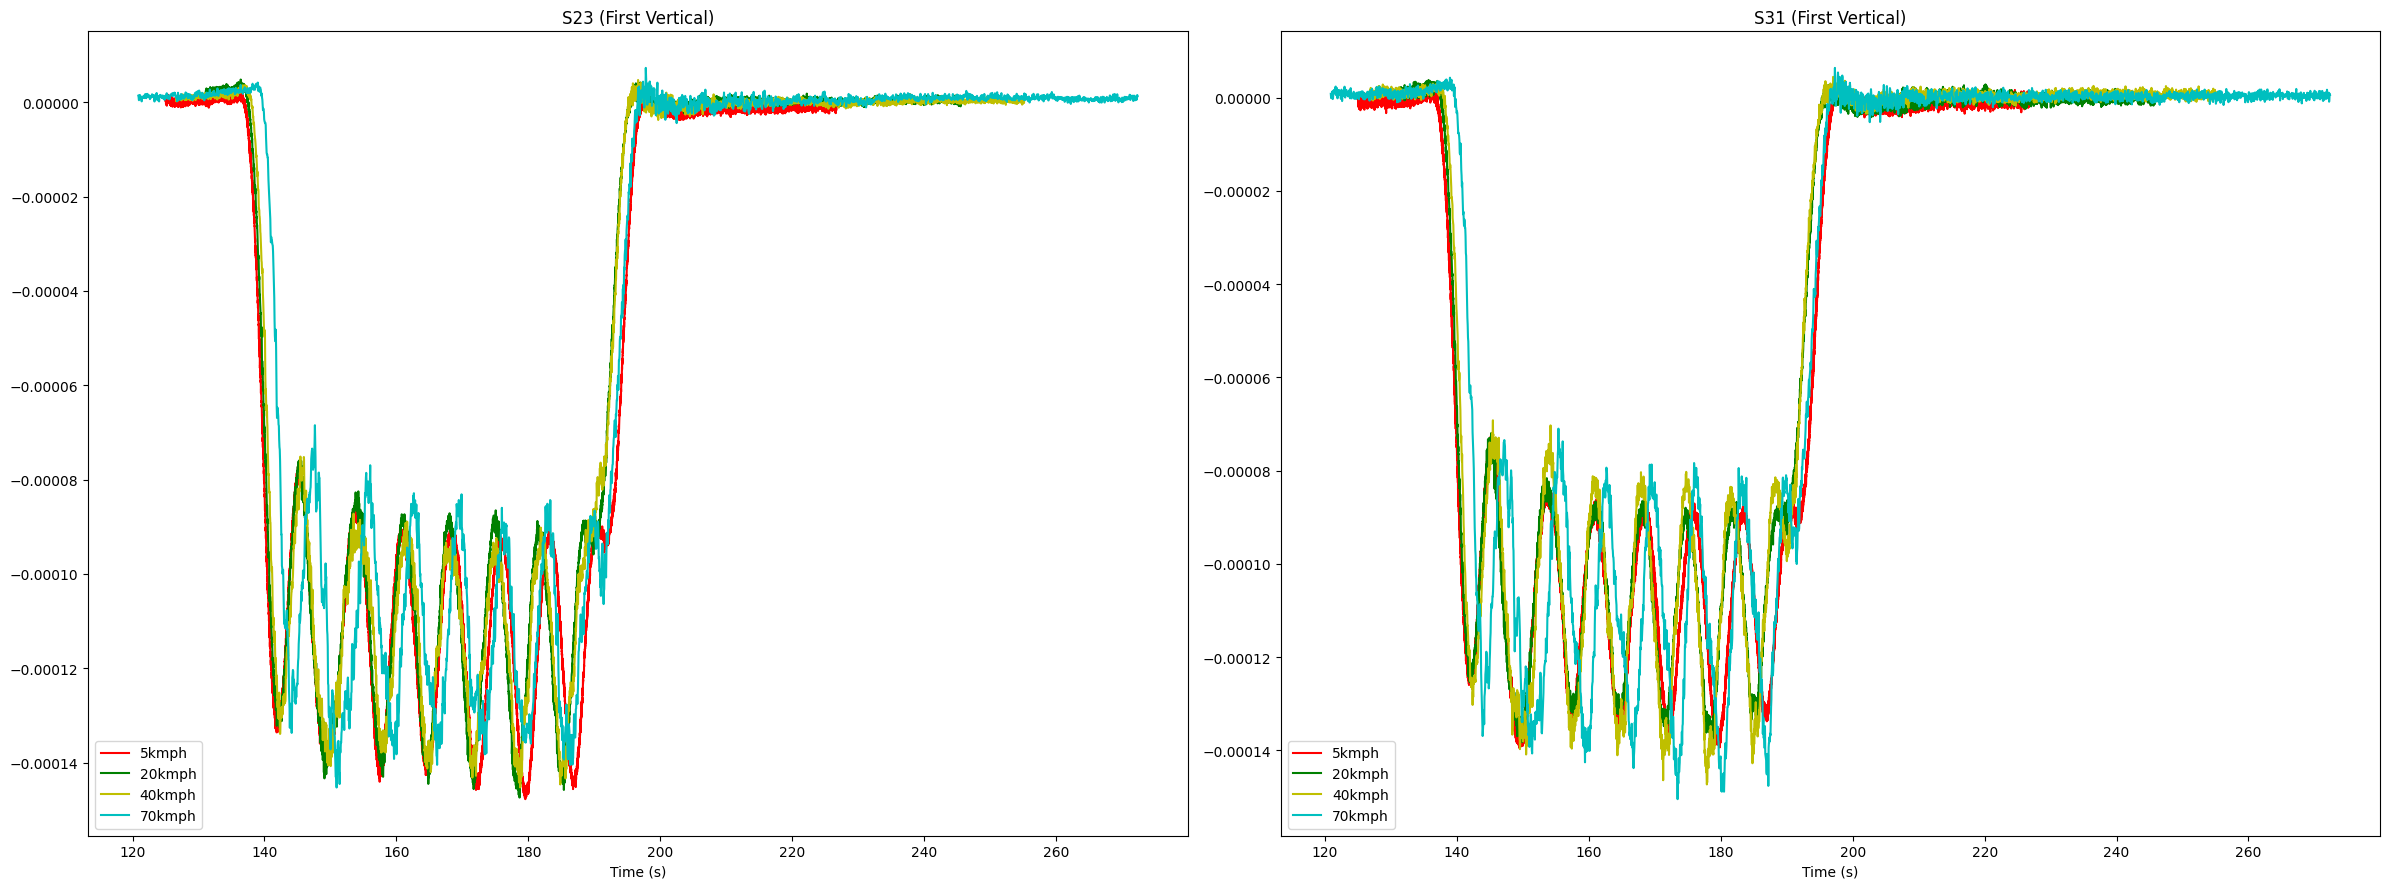

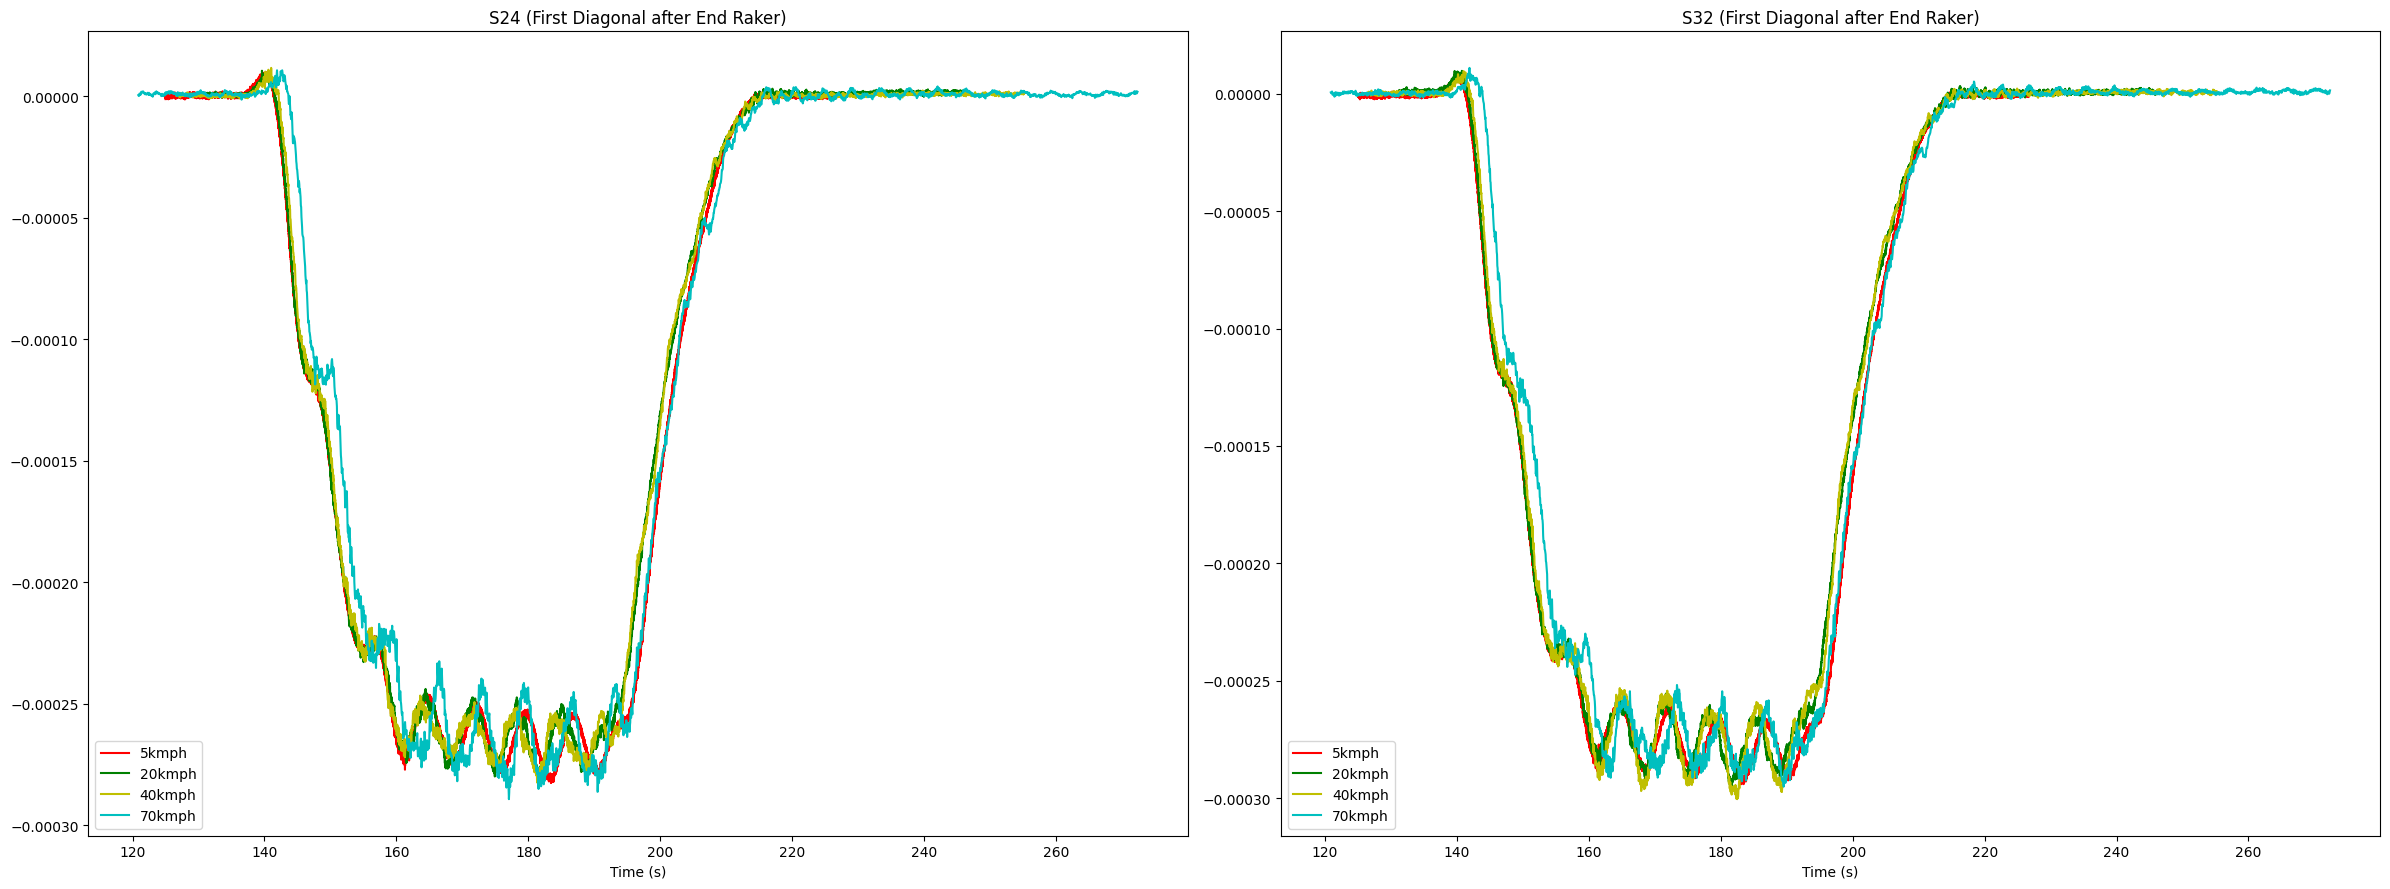

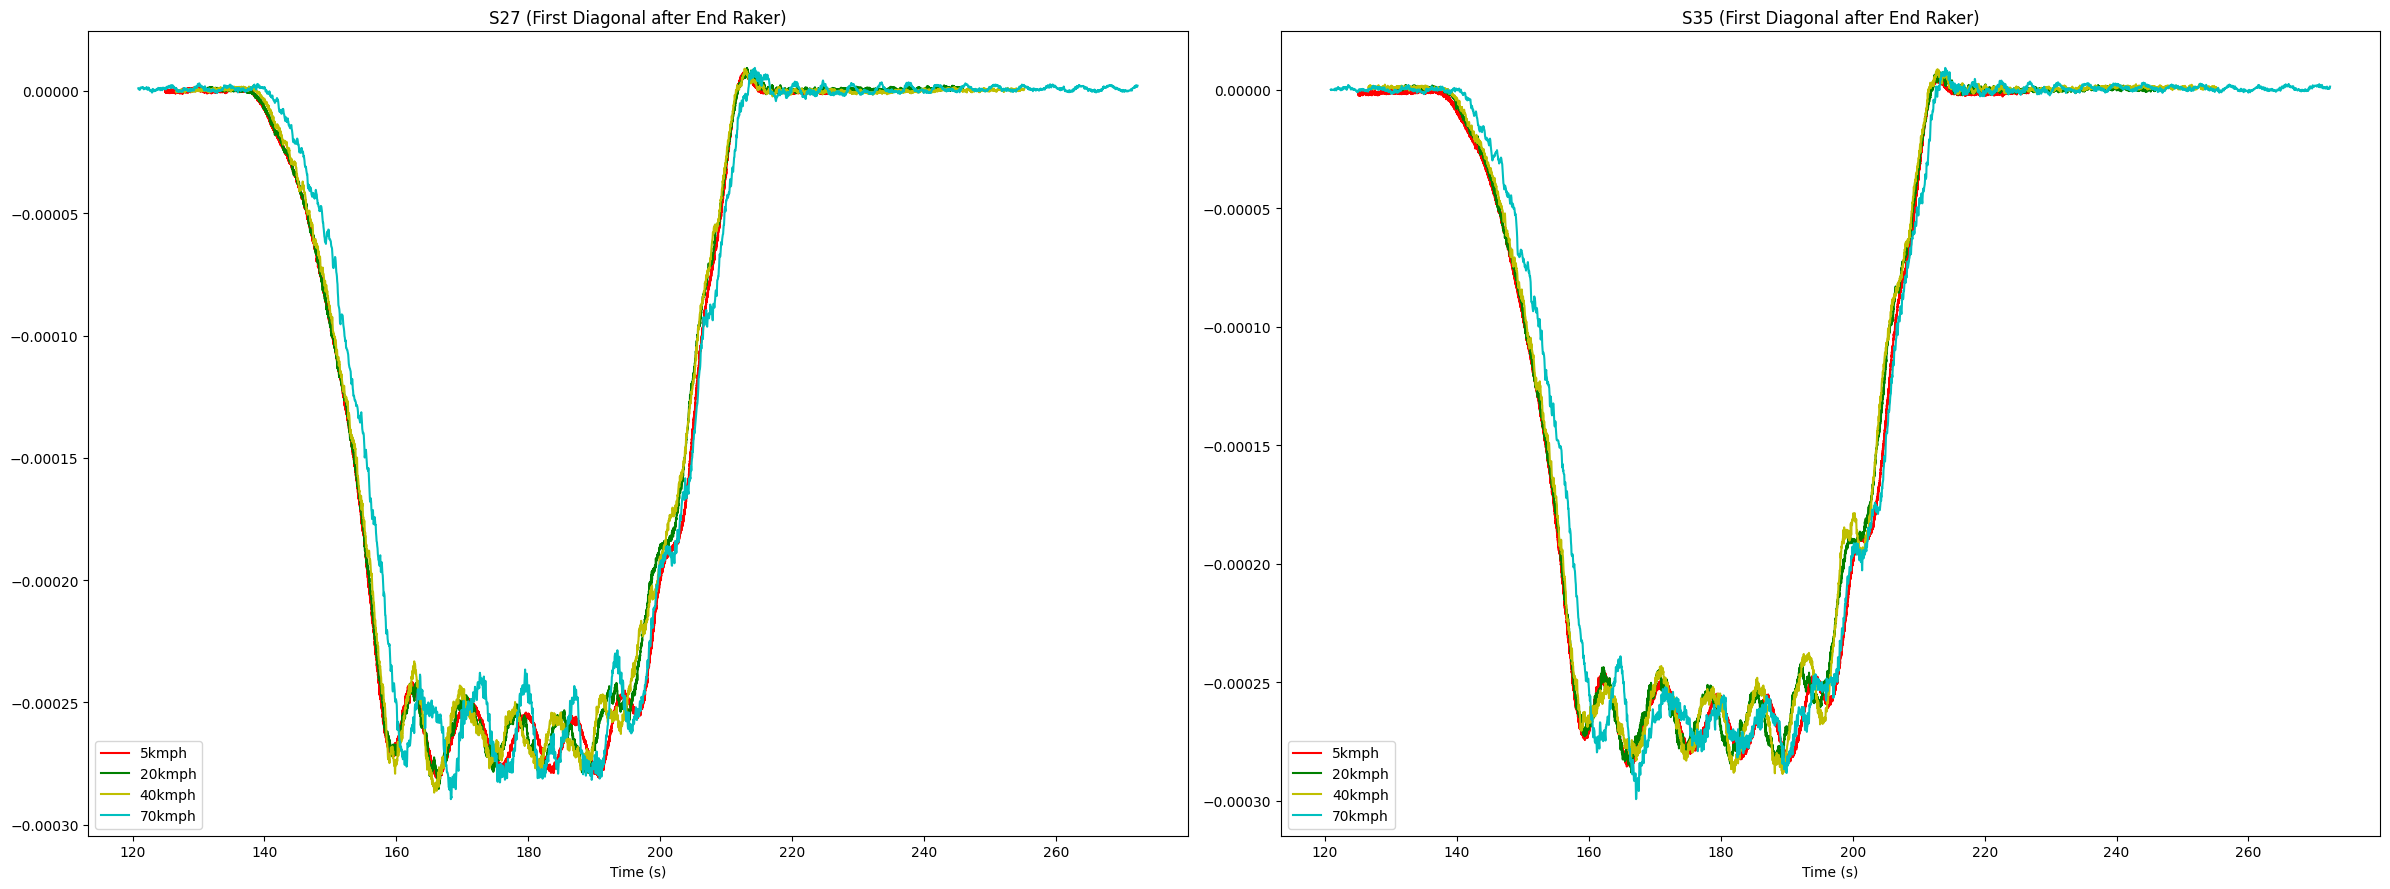

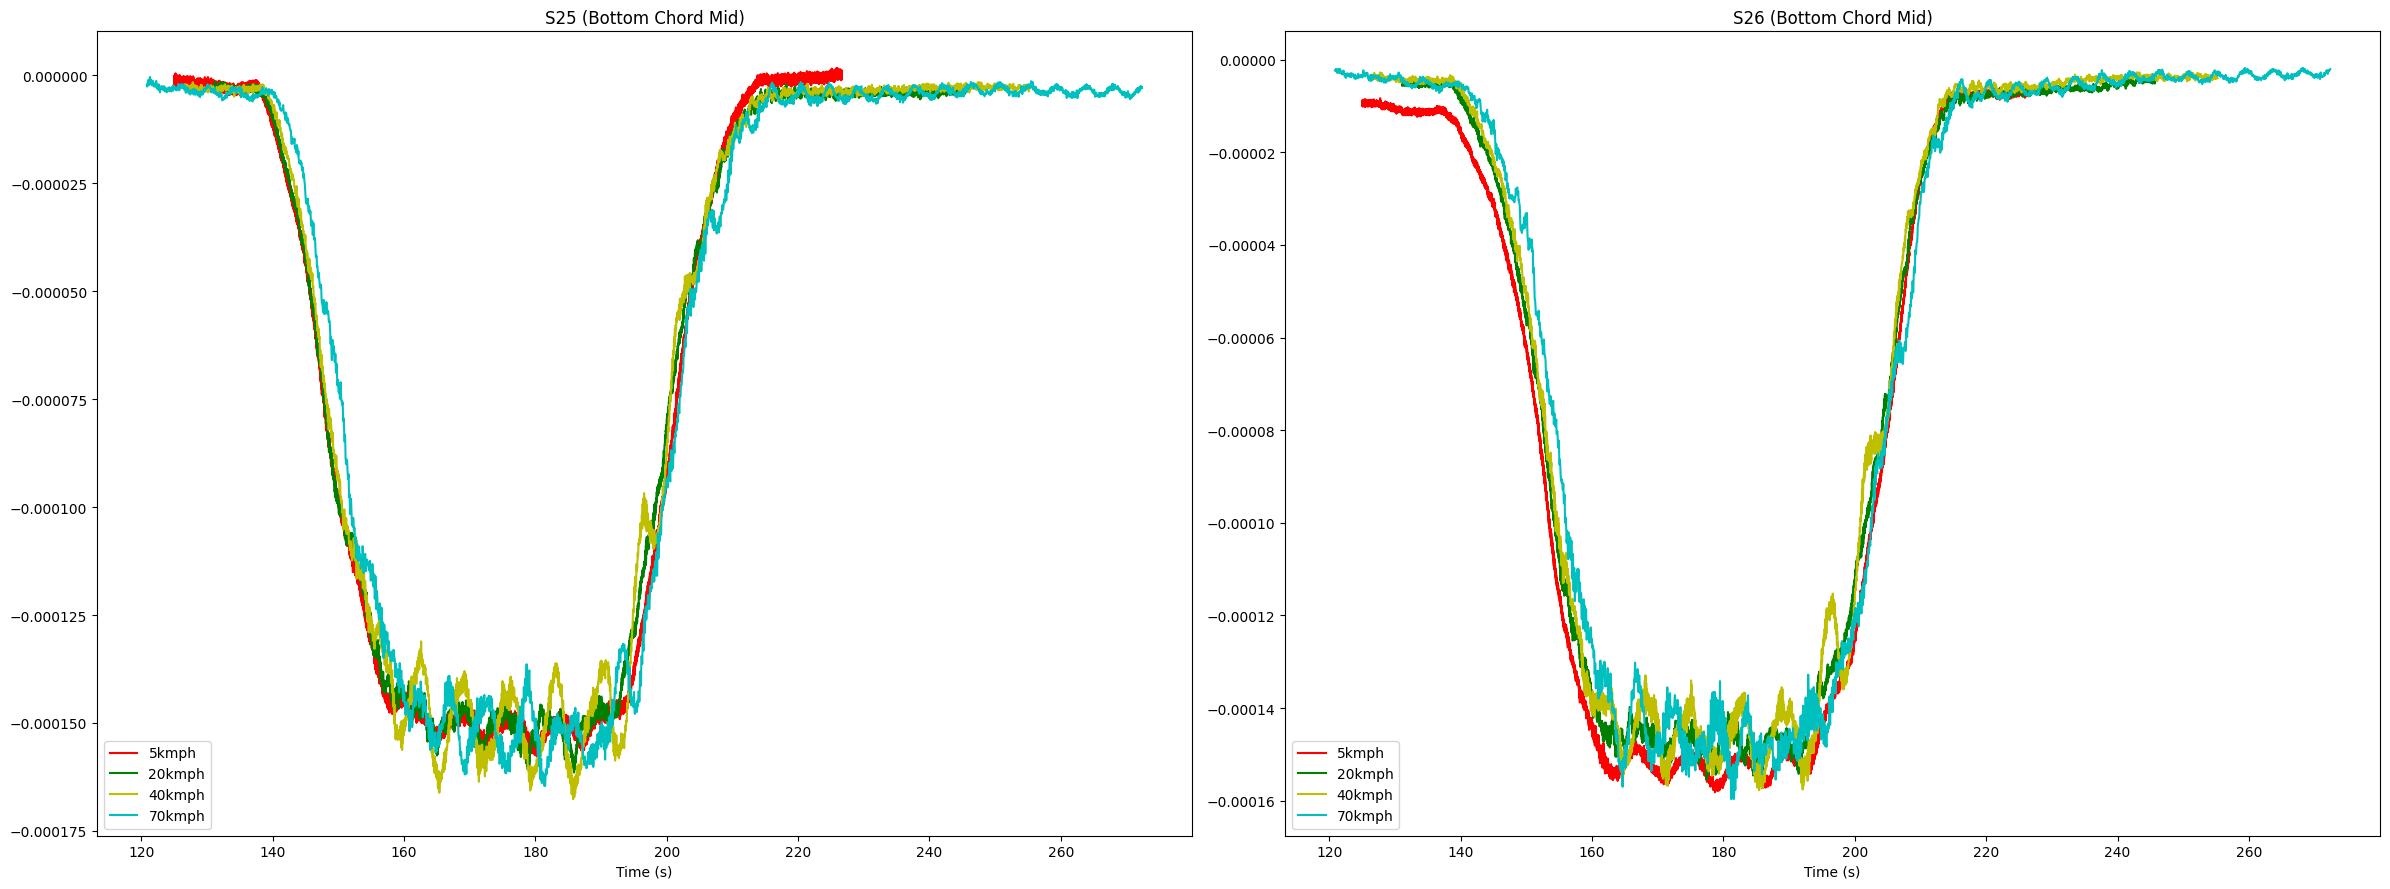

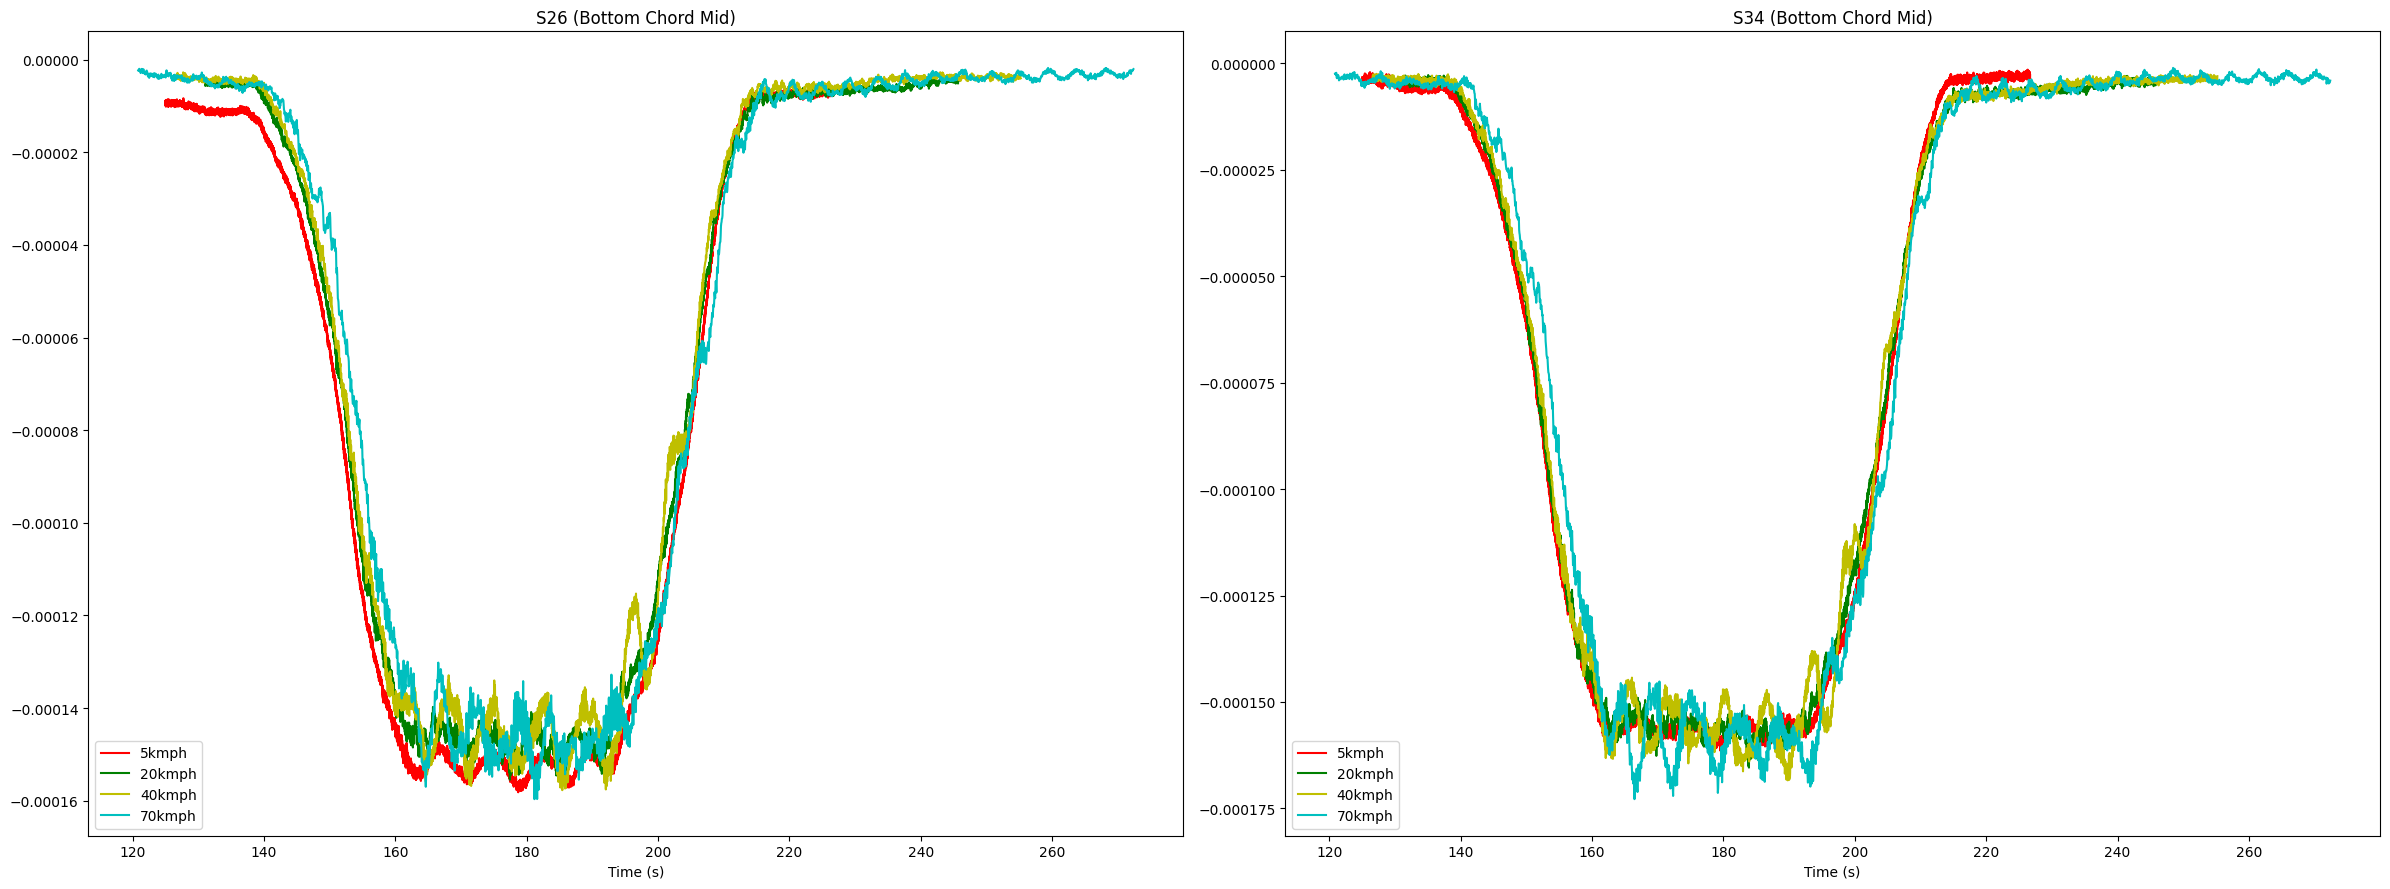

In [28]:
# Plotting the sets of graphs
from typing import Union
import matplotlib.pyplot as plt
import pandas as pd

def plotSets(_dfSensorsTuple:list[tuple[str, pd.DataFrame, str]]):
  _plotSets = [
    ('d5', 'd6'),
    ('S21', 'S29'), ('S28', 'S36'),
    ('S22', 'S30'),
    ('S23', 'S31'),
    ('S24', 'S32'), ('S27', 'S35'),
    ('S25', 'S26'), ('S26', 'S34'),
  ]
  _plotTitles = [
    ('d5 (Vertical LVDT)', 'd6 (Vectical LVDT)'),
    ('S21 (End Raker)', 'S29 (End Raker)'), ('S28 (End Raker)', 'S36 (End Raker)'),
    ('S22 (Bottom Chord near Support)', 'S30 (Bottom Chord near Support)'),
    ('S23 (First Vertical)', 'S31 (First Vertical)'),
    ('S24 (First Diagonal after End Raker)', 'S32 (First Diagonal after End Raker)'), ('S27 (First Diagonal after End Raker)', 'S35 (First Diagonal after End Raker)'),
    ('S25 (Bottom Chord Mid)', 'S26 (Bottom Chord Mid)'), ('S26 (Bottom Chord Mid)', 'S34 (Bottom Chord Mid)'),
  ]

  for __plotSet, __plotTitle in zip(_plotSets, _plotTitles):
    __fig, __axes = plt.subplots(1, len(__plotSet), figsize=(12*len(__plotSet),9), layout='tight')
    __filterRegex = r'^(' + r'|'.join(__plotSet) + r')'
    __legend = [] 
    for ___name, ___dfSensor, ___plotStyle in _dfSensorsTuple:
      ___dfSensor.filter(regex=__filterRegex).plot(subplots=True, ax=__axes, style=___plotStyle, title=__plotTitle)
      __legend.append(___name)
    for ___ax in __axes:
      ___ax.legend(__legend)
    plt.show()

plotSets([
  ("5kmph", dfSensor5, "r-"),
  ("20kmph", dfSensor20, "g-"),
  ("40kmph", dfSensor40, "y-"),
  ("70kmph", dfSensor70, "c-"),
])